In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

#### Helper functions

In [2]:
# target encoding of genre feature
cat_cols = ['artists', 'track_genre']

def target_encode_genre(cat_cols, X_train, X_test, y_train):

    df = X_train.join(y_train)
    
    for col in cat_cols:
    
        col_target_map = df.groupby(col)["popularity"].mean()
        global_mean = y_train.mean()

        X_train[f"{col}_popularity"] = X_train[col].map(col_target_map).fillna(global_mean)
        X_test[f"{col}_popularity"]  = X_test[col].map(col_target_map).fillna(global_mean)
        
        X_train = X_train.drop(columns=[col])
        X_test  = X_test.drop(columns=[col])
    
    return X_train, X_test, y_train

#### Data Loading

In [ ]:
# load data
df = pd.read_csv("../data/dataset_fe.csv")

In [4]:
# set-up a variable to decided whether or not we want to target encode categorical variables
target_encoding=False

In [5]:
# drop categorical features if not target encoding
if not target_encoding:
    df.drop(columns=['artists', 'track_genre'], inplace=True)

In [6]:
# train-val-test split data
X = df.drop(columns=["popularity"])
y = df["popularity"]

# 60% train, 20% val, 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [7]:
# encode categorical variables in train and validation dataset
if target_encoding:
    X_train, X_val, y_train = target_encode_genre(
        cat_cols=cat_cols,
        X_train=X_train,
        X_test=X_val,
        y_train=y_train
    )

#### Model comparison

In [ ]:
# dictionary of vanilla models to test
models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoostRegressor': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBMRegressor': lgb.LGBMRegressor(n_estimators=100, random_state=42),
}

In [ ]:
# print RMSE for each model fitte on train dataset and evaluated on validation dataset
for model_name, model in models.items():
    print (f"\nFitting model {model_name}...")
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    print("RMSE:", np.sqrt(mean_squared_error(y_val, y_preds)))


Fitting model RandomForestRegressor...
RMSE: 16.4174432165787

Fitting model XGBoostRegressor...
RMSE: 19.115003578770427

Fitting model LightGBMRegressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3593
[LightGBM] [Info] Number of data points in the train set: 64149, number of used features: 19
[LightGBM] [Info] Start training from score 35.291369
RMSE: 19.616429906874952


Conclusion: Despite the RandomForestRegressor having slightly better scores, I decided to go with the XGBRegressor model since the performance was fairly similar but much quicker to train.

#### Model Optimization

In [ ]:
# set xgb model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

In [ ]:
# grid-search for xgb model
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6],
    'learning_rate': [0.001, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=3
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'learning_rate': [0.001, 0.05, ...], 'max_depth': [3, 6], 'n_estimators': [100, 200, ...], 'subsample': [0.8, 1.0]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [13]:
best_params=grid_search.best_params_
print("Best Params:", best_params)

Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.8}


In [14]:
best_model = grid_search.best_estimator_
best_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [15]:
preds = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f"Validation RMSE: {rmse:.2f}")

Validation RMSE: 17.78


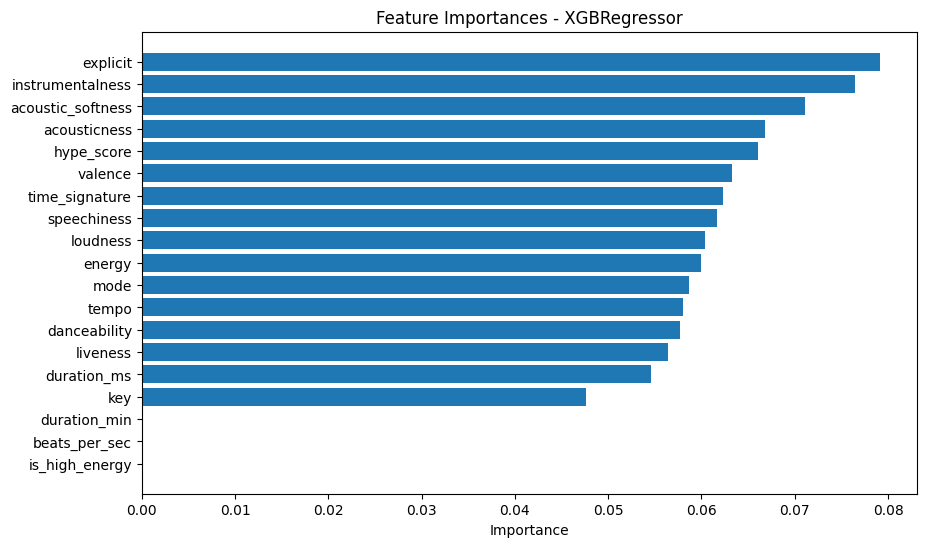

In [16]:
# 'best_model' is the fitted XGBRegressor from your GridSearch
importances = best_model.feature_importances_

# Map to feature names
feature_names = X_train.columns
feat_imp_df = pd.DataFrame(
    {
        'feature': feature_names,
        'importance': importances
    }
)

# Sort by importance descending
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importances - XGBRegressor")
plt.show()

Note: I should add that target encoding the "track_genre" and "artists" features led to slightly better RMSE scores, however in those models these features completely dominated in terms of importance compared to the others. Therefore, in order to try to have models that generalize better and relied more on the song features themselves, I opted to not target-encode those features in the final model.